In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox

from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

data_2020 = pd.read_csv('../../data/2020_Notebook02_train_output.csv')

try:
    data_2020.drop('Unnamed: 0',axis=1,inplace=True)
except:
    pass

#We built an extra feature that is not included in notebook2 output. If i have Price per total square meter.
#To build Price per constructed meter I'll have to pivot values.
data_2020['Precio_m2_constr'] = (data_2020['Precio_m2_total'] * data_2020['Area_total'])/data_2020['Area_constr']


#We restricted data only for Lima and Callao.

filter_1 = (data_2020['Ciudad'].isin(['Lima','Callao','Cañete']))
filter_2 = (data_2020['latitud']!= 0)

data_2020.where(filter_1 & filter_2 , inplace=True)

#Import the Lima Shape File per districts.

peru_districts = geopandas.read_file('../../data/GeoShape_Distritos/DISTRITOS.shp')
lima_districts = peru_districts[peru_districts['DEPARTAMEN'] == 'LIMA']

#Aggregate Polygons geometries to get Lima Department Polygon:
lima_department = geopandas.GeoSeries([lima_districts[lima_districts['DEPARTAMEN']=='LIMA'].unary_union])

#Aggregate Polygons geometries to get Lima District Polygon:
lima_province = geopandas.GeoSeries([lima_districts[lima_districts['PROVINCIA']=='LIMA'].unary_union])

#We only awant districts inside Lima.
lima_filter = (peru_districts['DEPARTAMEN'] == 'LIMA') 

lima_districts = peru_districts[lima_filter]

#We need shapely object. We can transform lats and longs into a shapely.Point object

gdf = geopandas.GeoDataFrame(
    data_2020, geometry=geopandas.points_from_xy(data_2020.longitud, data_2020.latitud))

gdf = gdf[gdf['geometry'].apply(lambda x: x.within(lima_department.values[0]))]

#Temporal drop: Since there are many outliers we'll drop some values.
# -------------------------------------------------------------------
gdf = gdf[gdf['Precio_m2_total'] < 9000]

gdf = gdf[gdf['Precio_m2_constr']<11000]

In [2]:
#Now you'll see a Geometry POINT was made as a column on our GeoDataFrame. We have built our GeoDataFrame
gdf

,latitud,longitud,Barrio,Ciudad,Area_total,Area_constr,MONEDA,Area_constr_cat,NroBanios,Dormitorios,...,areas_proporcion,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9,diff_total_mean_district,Precio_m2_total,Precio_m2_constr,geometry
0,-12.119831,-77.016015,Miraflores,Lima,398.0,352.0,S/,11.0,4.0,4.0,...,1.130682,6mc5p,6mc5p3,6mc5p3w,6mc5p3ws,6mc5p3wsu,258.315217,6550.251256,7406.250000,POINT (-77.01601 -12.11983)
1,-12.080734,-76.914384,La Molina,Lima,750.0,550.0,S/,17.0,4.0,4.0,...,1.363636,6mc73,6mc73b,6mc73bb,6mc73bb8,6mc73bb8s,205.376812,6030.000000,8222.727273,POINT (-76.91438 -12.08073)
2,-12.089309,-76.935051,La Molina,Lima,1080.0,600.0,USD,18.0,4.0,4.0,...,1.800000,6mc71,6mc71r,6mc71r1,6mc71r1w,6mc71r1we,-27.605863,4212.962963,7583.333333,POINT (-76.93505 -12.08931)
4,-12.093773,-77.067285,Magdalena,Lima,816.0,815.0,S/,19.0,5.0,7.0,...,1.001227,6mc5n,6mc5nq,6mc5nq3,6mc5nq3k,6mc5nq3kd,-398.451049,5147.058824,5153.374233,POINT (-77.06728 -12.09377)
5,-12.214983,-77.009185,Chorrillos,Lima,1200.0,570.0,USD,18.0,4.0,5.0,...,2.105263,6mc4x,6mc4x8,6mc4x87,6mc4x87d,6mc4x87de,-30.451049,3500.000000,7368.421053,POINT (-77.00918 -12.21498)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,-12.066539,-76.911124,La Molina,Lima,1300.0,500.0,S/,17.0,4.0,4.0,...,2.600000,6mc73,6mc73g,6mc73g7,6mc73g75,6mc73g752,-114.605863,3320.000000,8632.000000,POINT (-76.91112 -12.06654)
4702,-12.073589,-76.886133,La Molina,Lima,855.0,397.0,S/,13.0,4.0,4.0,...,2.153652,6mc76,6mc766,6mc766j,6mc766j4,6mc766j4p,-493.254902,2776.608187,5979.848866,POINT (-76.88613 -12.07359)
4703,-12.354781,-76.809923,Punta Negra,Lima,437.0,340.0,S/,11.0,4.0,4.0,...,1.285294,6mc3s,6mc3sn,6mc3snu,6mc3snus,6mc3snusp,-303.451049,5242.105263,6737.647059,POINT (-76.80992 -12.35478)
4704,-12.108089,-76.960098,Santiago de Surco,Lima,300.0,563.0,USD,18.0,4.0,4.0,...,0.532860,6mc70,6mc70e,6mc70ez,6mc70ez3,6mc70ez37,691.766534,7583.333333,4040.852575,POINT (-76.96010 -12.10809)


### Quick Country View

Since it always can be bad inputed coordinates, we'll see first if everything is inside Perú.

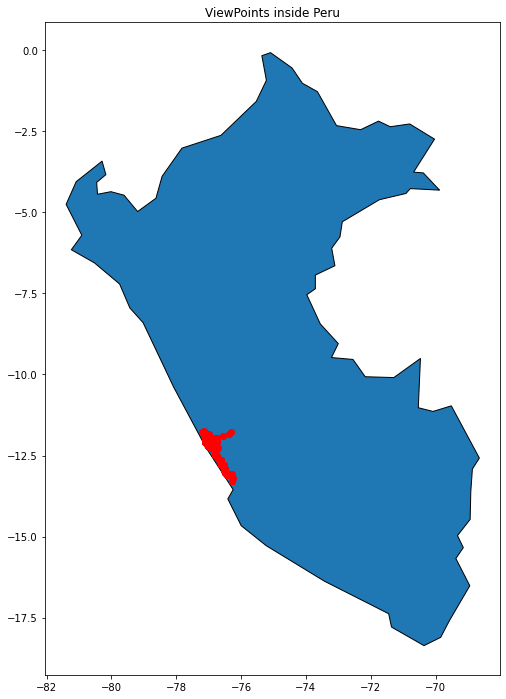

In [3]:
#Importing the world GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 

#And get Perú from it
ax = world[world['iso_a3'] == 'PER'].plot(edgecolor='black', figsize=(18,12))

#Now we can plot our GeoDataFrame
plt.title('ViewPoints inside Peru')
gdf.plot(ax=ax, color = 'red')
plt.show()

### Ploting inside Lima.

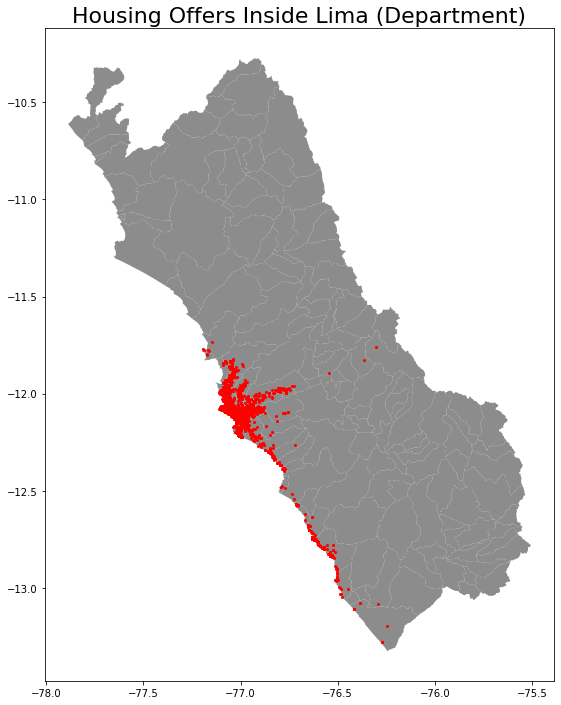

In [4]:
#Remember that lima_districts contains a GeoDataFra of Lima.

fig, ax = plt.subplots(figsize=(18,12))
lima_districts.plot(ax=ax, color='grey', alpha=0.9)
gdf.plot(ax=ax, markersize=4, color="red", marker="o") #Our Housing Data.
plt.title('Housing Offers Inside Lima (Department)', size=22)
plt.show()

Wee see here there is more density around Lima Province, which is made out of few districts. So we should focus on this area.

### Plotting Lima Province

In [5]:
# We filter all of housing point that are inside Lima as a Province.
gdf_province = gdf[gdf['geometry'].apply(lambda x: x.within(lima_province.values[0]))]

Text(0.5, 1.0, 'Housing Offers Inside Lima (Province)')

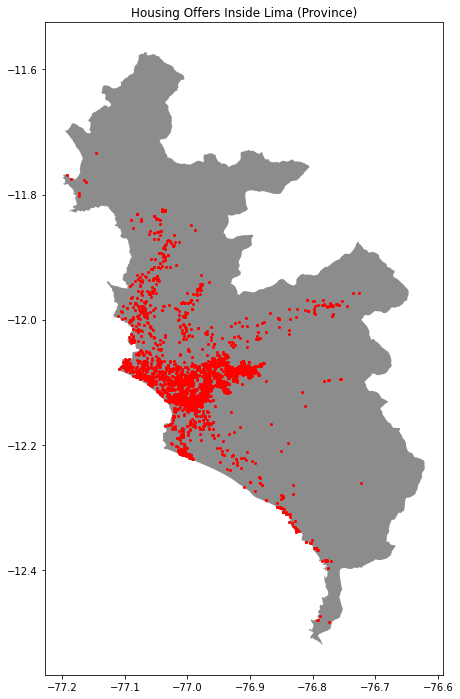

In [6]:
#lima_province = lima_districts[lima_districts['PROVINCIA']=='LIMA']
fig, ax = plt.subplots(figsize=(18,12))
lima_province.plot(ax=ax, color='grey', alpha=0.9)
gdf_province.plot(ax=ax, markersize=4, color="red", marker="o")
plt.title("Housing Offers Inside Lima (Province)")

### Can we see distributions of prices within a map?

In our previous pre-processing analysis we build [GeoHashes](https://en.wikipedia.org/wiki/Geohash) as a feature to clasify the space we are working with. Then, we could build some price density around this GeoHashes.

In [7]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

def make_density_geohash_plot(gdf_province, geohash_level=6, scaler = MinMaxScaler(),\
                              column_to_plot='Precio_m2_total', title="Sq-meter Price density",\
                              ax=None):
    """
    gdf_province: GeoDataFrame of Provinces
    geohash_level: GeoHash level
    scaler: How we will scale the prices. We also could use QuantileTransformer(output_distribution='normal')
    column_to_plot: GeoDataFrame column name
    """

    agg = gdf_province.groupby(['geohash_grado{}'.format(geohash_level)], as_index=False).agg({
                                                                  column_to_plot:"mean",
                                                                  "latitud":"first",
                                                                  "longitud":"first",
                                                                  "geometry":"first"})
    
    
    
    geo_agg = geopandas.GeoDataFrame(agg, crs={"init":"epsg:4326"}, geometry=agg["geometry"])
    
    geo_agg[f"{column_to_plot}_size"] = scaler.fit_transform(geo_agg[[column_to_plot]])
    
    max_amount = float(geo_agg[column_to_plot].max()) 
    
    fig, ax = plt.subplots(figsize=(18,12))
    
    lima_province.plot(ax=ax,color='grey', alpha=0.70) #Plot map
    
    geo_agg.plot(column=column_to_plot, #Plot points
                  ax=ax, markersize=100 * geo_agg[f"{column_to_plot}_size"],  marker="o", vmax=max_amount,
                  cmap="Greens",legend=True)
    
    #Cleanind the ticks
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(title+f' GH-{str(geohash_level)}')
    plt.show()

In [8]:
#plt.figure()

#Square Meter Price Density, with MinMax Scaler
#make_density_geohash_plot(gdf_province, geohash_level=6, scaler = MinMaxScaler(),\
#                              column_to_plot='Precio_m2_total')

#Square Meter Price Density, with Normalized Scaler

#make_density_geohash_plot(gdf_province, geohash_level=6, scaler = QuantileTransformer(output_distribution='normal'),\
#                              column_to_plot='Precio_m2_total', title='Sq-meter Price density (Normalized)')

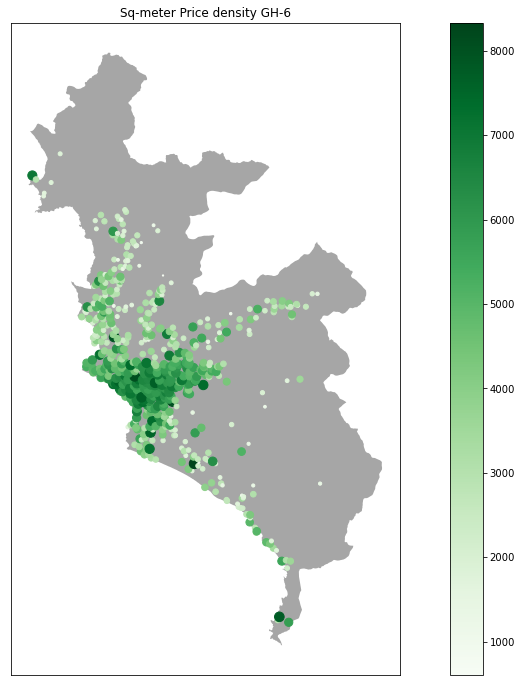

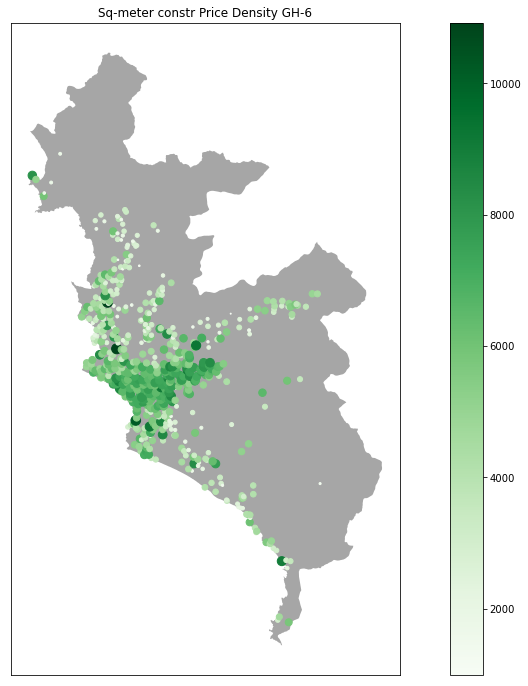

In [9]:
quantile_scaler = QuantileTransformer(output_distribution='normal')

make_density_geohash_plot(gdf_province, geohash_level=6, scaler = MinMaxScaler(),\
                              column_to_plot='Precio_m2_total')

make_density_geohash_plot(gdf_province, geohash_level=6, scaler = MinMaxScaler(),\
                              column_to_plot='Precio_m2_constr', title='Sq-meter constr Price Density')

With the plot above we could say that expensive houses by area are spread around the Lima Center also know as 'Lima Monderna' which is expected since the average salary is higher there. Also we see that the square constructed meters cost has more differences across the districts.

#### But what about House Sizes?

In which part of Lima are there high size offer houses?

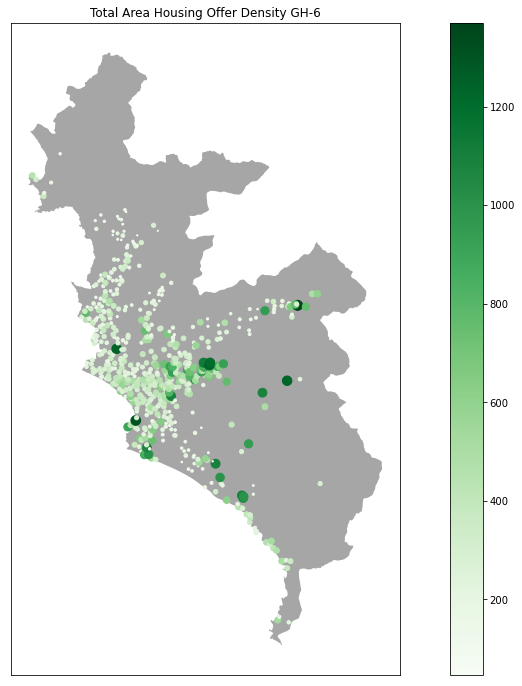

In [10]:
make_density_geohash_plot(gdf_province, geohash_level=6, scaler = MinMaxScaler(),\
                              column_to_plot='Area_total', title='Total Area Housing Offer Density')

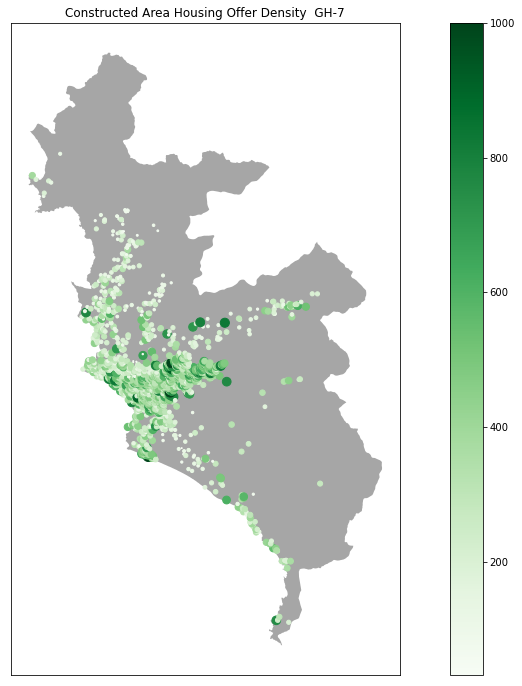

In [11]:
#More Constructed areas hoses

make_density_geohash_plot(gdf_province, geohash_level=7, scaler = MinMaxScaler(),\
                              column_to_plot='Area_constr', title='Constructed Area Housing Offer Density ')

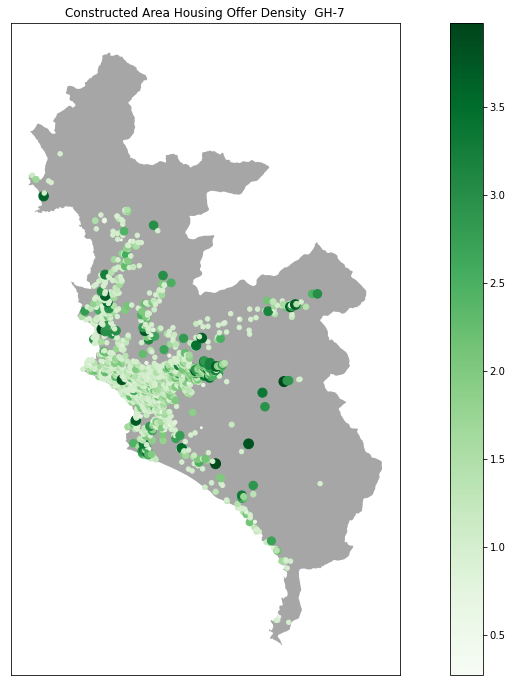

In [12]:
#With High Total Ratio / Total Constructed area

make_density_geohash_plot(gdf_province, geohash_level=7, scaler = MinMaxScaler(),\
                              column_to_plot='areas_proporcion', title='Constructed Area Housing Offer Density ')

### Choropleths

We'll use [Fisher-Jenk](https://pbpython.com/natural-breaks.html) Natural Breaks to classify our data inside the Choropleths. This method was made exactly for choropleths and make splits that are more reliable in our plots.

In [13]:
#Instead of correcting the 'Barrio' column we will make a SpatialJoin to our data.

from geopandas.tools import sjoin
lima_district_ = lima_districts[lima_districts['PROVINCIA'] == 'LIMA']
lima_district_.drop(['IDDPTO','DEPARTAMEN','IDPROV','PROVINCIA','IDDIST','CAPITAL','CODCCPP','AREA','FUENTE'],axis=1,inplace=True)

gdf_join = sjoin(lima_district_,gdf, how='inner').drop(['index_right','Barrio'],axis=1)

In [14]:
#Then we will extract numeric features by District
agg_gdf_quant = gdf_join.groupby(['DISTRITO'])[['Area_total','Area_constr','areas_proporcion','Precio_m2_total','Precio_m2_constr']].agg('median').reset_index()

#And store the Polygons per District
agg_gdf_geom = gdf_join.groupby(gdf_join['DISTRITO'])['geometry'].first().reset_index()

final_joined = agg_gdf_quant.merge(agg_gdf_geom, on='DISTRITO', how='left')

Text(0.5, 1.0, 'Total Area Sq-meter Median Price')

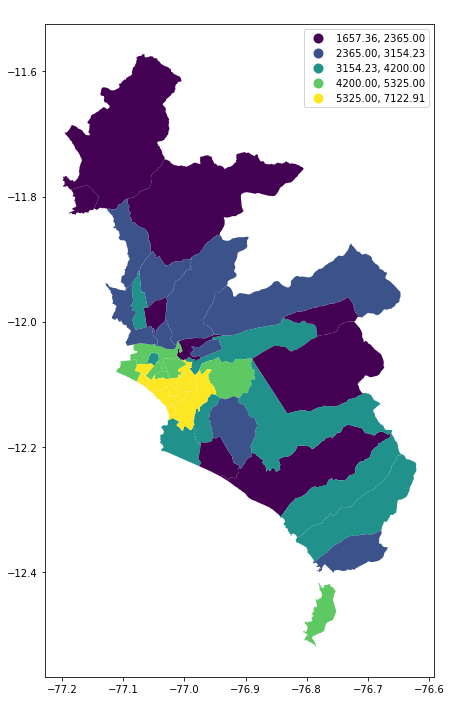

In [15]:
fig, ax = plt.subplots(figsize=(18,12))
final_joined.plot(column='Precio_m2_total',ax=ax,  legend=True, scheme='fisher_jenks')
plt.title('Total Area Sq-meter Median Price', size=16, color='white')

Text(0.5, 1.0, 'Constructed Area Sq-meter Median Price')

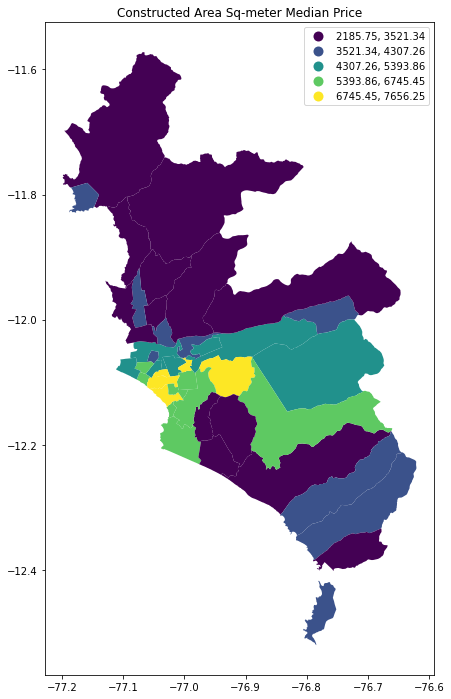

In [16]:
fig, ax = plt.subplots(figsize=(18,12))
final_joined.plot(column='Precio_m2_constr', ax=ax, legend=True,  scheme='fisher_jenks')
plt.title('Constructed Area Sq-meter Median Price')

Text(0.5, 1.0, 'Total Area per Offer Houses')

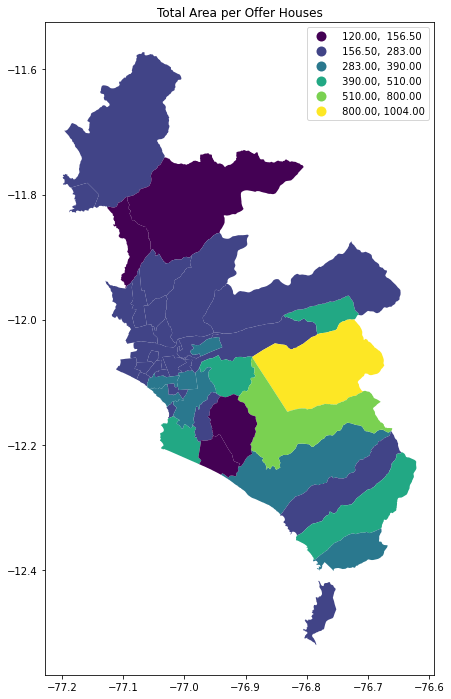

In [17]:
fig, ax = plt.subplots(figsize=(18,12))
final_joined.plot(column='Area_total', ax=ax, legend=True, scheme='fisher_jenks',k=6)
plt.title('Total Area per Offer Houses')

Text(0.5, 1.0, 'Total Area/Area_constr Sq-meter Median Price')

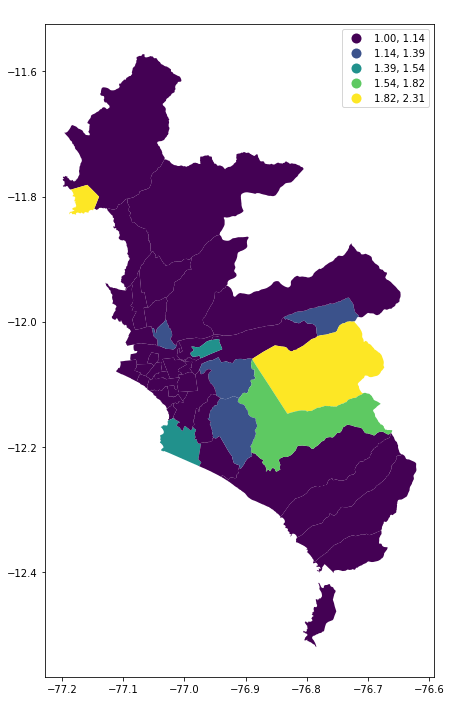

In [18]:
fig, ax = plt.subplots(figsize=(18,12))
final_joined.plot(column='areas_proporcion',ax=ax,  legend=True, scheme='fisher_jenks')
plt.title('Total Area/Area_constr Sq-meter Median Price', size=16, color='white')

##### References:


https://medium.com/analytics-vidhya/the-beginners-guide-to-choropleth-maps-in-python-ff1da28a8943

https://pbpython.com/natural-breaks.html

https://www.youtube.com/watch?v=kJXUUO5M4ok

https://github.com/geopandas/scipy2018-geospatial-data

https://geographicdata.science/book